# Time Series Analysis

## Housing Prices

### Lynn Anderson

# Overview

The aim of this project was to .... TS models are .........




# Business Understanding


# Data Understanding

The dataset consisted of a csv file obtained from Zillow.



# Data Preparation

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

%matplotlib inline

In [3]:
df = pd.read_csv("data/zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [6]:
df.isnull().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [8]:
df['RegionName'].nunique()

14723

In [9]:
df['City'].nunique()

7554

In [10]:
df['Metro'].nunique()

701

In [11]:
df['State'].nunique()

51

In [12]:
df['State'].unique()

array(['IL', 'TX', 'NY', 'CA', 'FL', 'TN', 'NC', 'GA', 'DC', 'MO', 'OK',
       'AZ', 'NJ', 'MD', 'VA', 'WA', 'OH', 'MI', 'MA', 'KS', 'NM', 'CT',
       'NV', 'PA', 'CO', 'OR', 'IN', 'SC', 'KY', 'AR', 'ND', 'MN', 'AL',
       'DE', 'LA', 'MS', 'ID', 'MT', 'HI', 'WI', 'UT', 'ME', 'SD', 'WV',
       'IA', 'RI', 'NE', 'WY', 'AK', 'NH', 'VT'], dtype=object)

def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [46]:
ca = df.loc[df['State'] == 'CA']
ca

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
64,97711,94501,Alameda,CA,San Francisco,Alameda,65,222400.0,222300.0,222400.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14683,97304,93517,Bridgeport,CA,NaN,Mono,14684,120900.0,121400.0,121800.0,...,287700,276300,263900,259000,259800,262600,264400,265900,269400,272500
14690,98404,95728,Truckee,CA,Truckee,Nevada,14691,147700.0,147800.0,148100.0,...,476900,488600,494100,491200,485700,482600,480900,483600,490500,496300
14692,98245,95497,Annapolis,CA,Santa Rosa,Sonoma,14693,307200.0,306300.0,305500.0,...,772800,778200,786100,792700,799100,806900,814600,824300,837100,848700
14709,96805,92322,Crestline,CA,Riverside,San Bernardino,14710,78700.0,78500.0,78300.0,...,180900,182600,184200,185700,187300,189100,189900,191600,195700,200100


In [48]:
ca['Metro'].value_counts()

Los Angeles-Long Beach-Anaheim    347
San Francisco                     134
Riverside                         116
Sacramento                         92
San Diego                          87
San Jose                           55
Fresno                             40
Bakersfield                        27
Santa Rosa                         25
Stockton                           25
Ventura                            23
Modesto                            19
Visalia                            19
Santa Maria-Santa Barbara          18
San Luis Obispo                    18
Salinas                            16
Santa Cruz                         12
Chico                              12
Vallejo                            11
Eureka                             11
Merced                             10
Madera                              9
Truckee                             8
Redding                             8
Yuba City                           8
Clearlake                           8
Napa        

In [49]:
ca['CountyName'].value_counts()

Los Angeles        264
San Diego           87
Orange              83
Riverside           60
San Bernardino      56
Santa Clara         52
Sacramento          46
Alameda             43
Fresno              40
Contra Costa        31
Kern                27
San Mateo           25
Sonoma              25
San Joaquin         25
Ventura             23
Placer              22
Stanislaus          19
San Francisco       19
Tulare              19
San Luis Obispo     18
Santa Barbara       18
El Dorado           16
Marin               16
Monterey            16
Santa Cruz          12
Butte               12
Solano              11
Humboldt            11
Merced              10
Madera               9
Yolo                 8
Shasta               8
Amador               8
Siskiyou             8
Lake                 8
Calaveras            8
Nevada               8
Napa                 7
Mendocino            6
Plumas               6
Imperial             5
Yuba                 4
Sutter               4
Kings      

In [58]:
bay_area = ca.loc[(ca['CountyName'] == 'Santa Clara') | (ca['CountyName'] == 'San Francisco')]
bay_area

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
76,97565,94110,San Francisco,CA,San Francisco,San Francisco,77,213900.0,214800.0,216000.0,...,1503000,1506400,1513500,1525200,1533600,1536500,1536200,1544400,1570000,1594000
244,97991,95123,San Jose,CA,San Jose,Santa Clara,245,224500.0,224800.0,225200.0,...,879400,894700,911900,931300,951900,970700,986100,1002200,1025400,1043900
289,97952,95051,Santa Clara,CA,San Jose,Santa Clara,290,258700.0,259300.0,259900.0,...,1252800,1287100,1326800,1365400,1405600,1444500,1476800,1508100,1547700,1577100
333,97576,94122,San Francisco,CA,San Francisco,San Francisco,334,278400.0,278300.0,278400.0,...,1321100,1330500,1344600,1361500,1372100,1378900,1386500,1394100,1405000,1414800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8256,97695,94305,Stanford,CA,San Jose,Santa Clara,8257,736900.0,744500.0,751900.0,...,3364000,3386400,3425800,3476800,3557100,3624600,3667000,3680000,3693200,3698800
9030,97939,95033,Lexington Hills,CA,San Jose,Santa Clara,9031,379100.0,382000.0,384900.0,...,1090500,1101700,1120800,1139800,1154300,1163300,1171500,1184000,1199100,1206700
9459,97987,95119,San Jose,CA,San Jose,Santa Clara,9460,229400.0,230300.0,231200.0,...,898200,913700,932200,956200,982500,1003600,1017700,1034200,1057600,1074200
10295,97950,95046,San Martin,CA,San Jose,Santa Clara,10296,343000.0,344900.0,346700.0,...,960000,970700,986700,1010400,1034800,1054000,1069600,1086200,1107800,1124100


In [59]:
bay_area['City'].value_counts()

San Jose           27
San Francisco      19
Santa Clara         3
Sunnyvale           3
Mountain View       3
Palo Alto           3
Los Altos           2
Los Gatos           2
Saratoga            1
Lexington Hills     1
Stanford            1
Morgan Hill         1
Gilroy              1
Campbell            1
Cupertino           1
Milpitas            1
San Martin          1
Name: City, dtype: int64

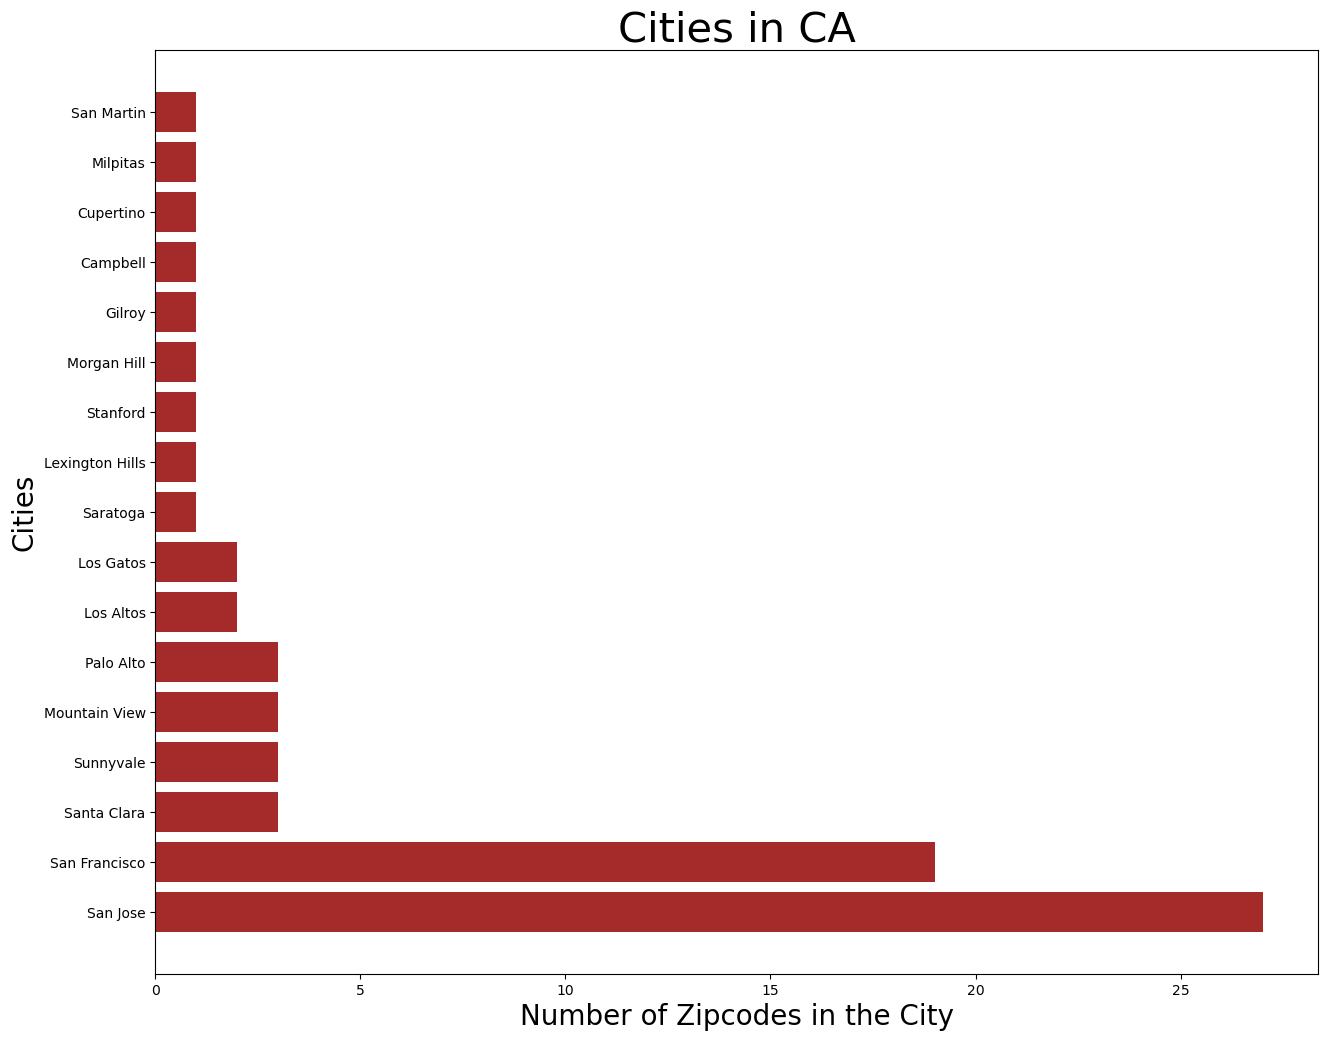

In [60]:
#Visualizing the value counts of zipcodes in each city in the Miami-Dade county

fig, ax = plt.subplots(figsize=(15,12))

y = [a for a in bay_area['City'].value_counts()]

x = [a for a in bay_area['City'].value_counts().keys()]

ax.barh(x,y,color='brown')
ax.set_title('Cities in CA',fontsize=30)
ax.set_ylabel('Cities',fontsize=20)
ax.set_xlabel('Number of Zipcodes in the City',fontsize=20);

In [62]:
bay_area_roi = bay_area
bay_area_roi['roi_since11'] = None
bay_area_roi['roi_since11'] = bay_area_roi['2018-04'].apply(lambda x : ((x - bay_area_roi['2011-01'])/(bay_area_roi['2011-01'])))
bay_area_roi = bay_area_roi.sort_values('roi_since11',ascending=False)


fig,ax=plt.subplots(figsize=(18,12))

x_labels = [str(a) for a in bay_area_roi['RegionName']]
x = list(range(1,17))
y = [a for a in bay_area_roi['roi_since11']]

ax.bar(x,y)

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([a/10 for a in list(range(0,17,1))])
ax.set_yticklabels([str(a*10)+'%' for a in list(range(0,17,1))])
ax.set_ylabel('% Growth',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on Investment',fontsize='30');

C:\Users\lalyn\AppData\Local\Temp\ipykernel_5684\1578830985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bay_area_roi['roi_since11'] = None


ValueError: Columns must be same length as key

# Data Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

### Reshape wide to long

In [1]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [15]:
long_df = melt_data(df)
long_df.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


In [16]:
long_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

In [18]:
long_df.isnull().sum()

value    0
dtype: int64

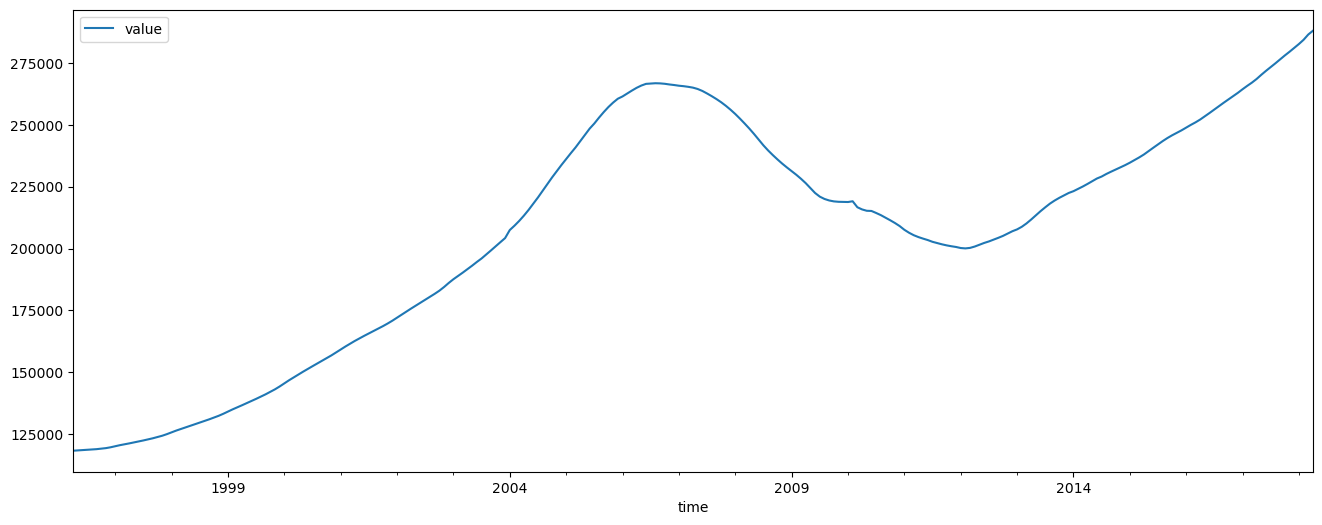

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

long_df.plot(figsize = (16,6));

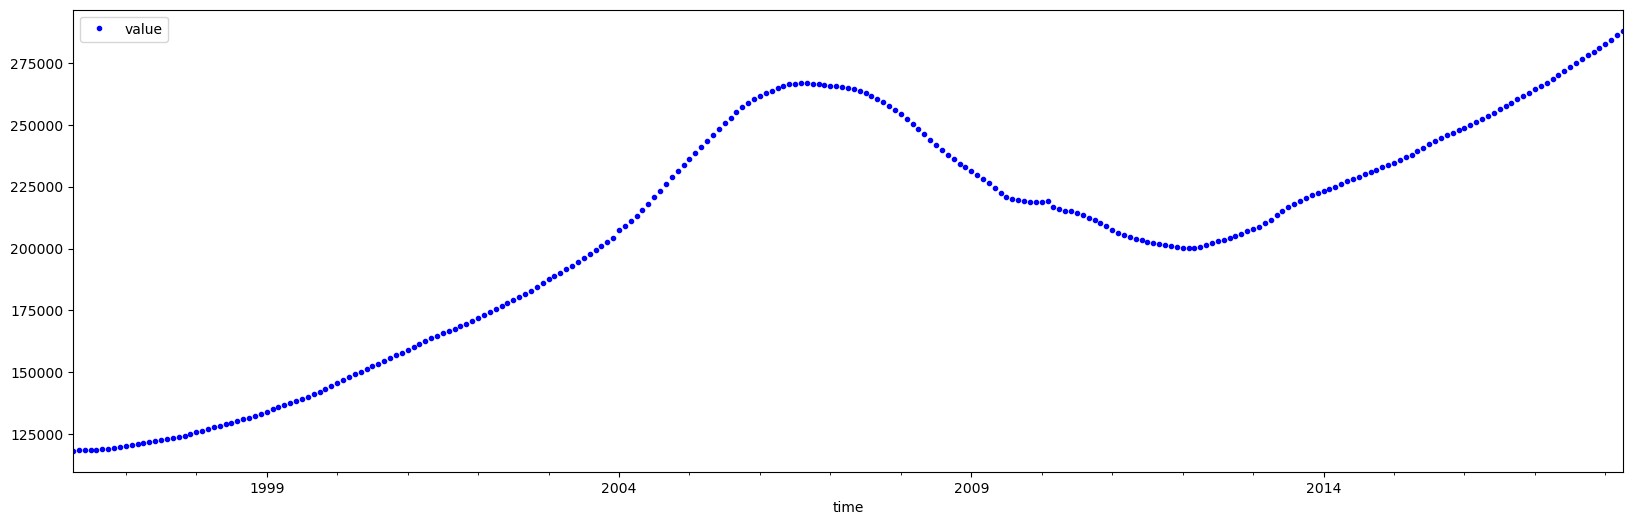

In [20]:
long_df.plot(figsize = (20,6), style = '.b');


In [21]:
year_groups = long_df.groupby(pd.Grouper(freq ='A'))
# Create a new DataFrame and store yearly values in columns 
long_df_annual = pd.DataFrame()

for yr, group in year_groups:
    long_df_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
long_df_annual.plot(figsize = (13,8), subplots=True, legend=True);

ValueError: Length of values (12) does not match length of index (9)

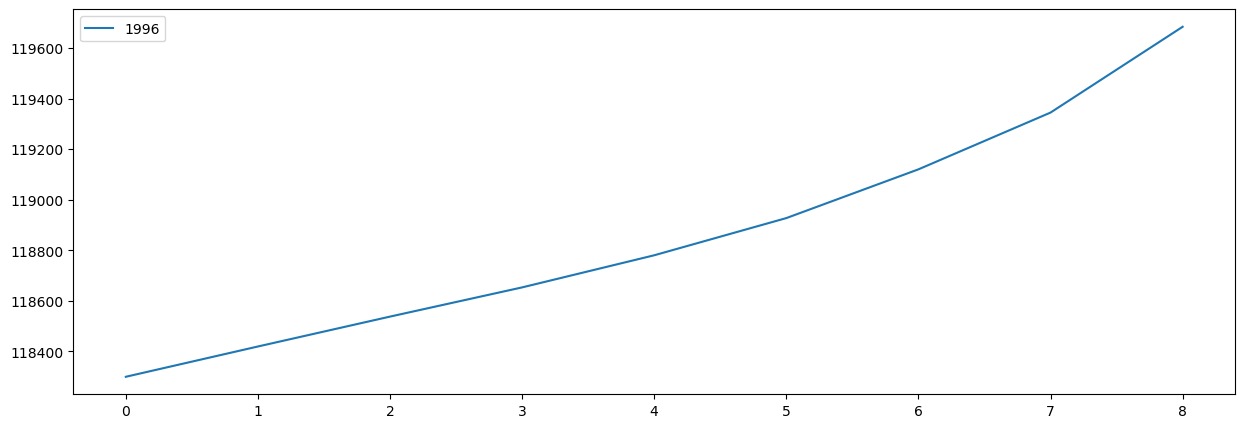

In [22]:
long_df_annual.plot(figsize = (15,5), subplots=False, legend=True);


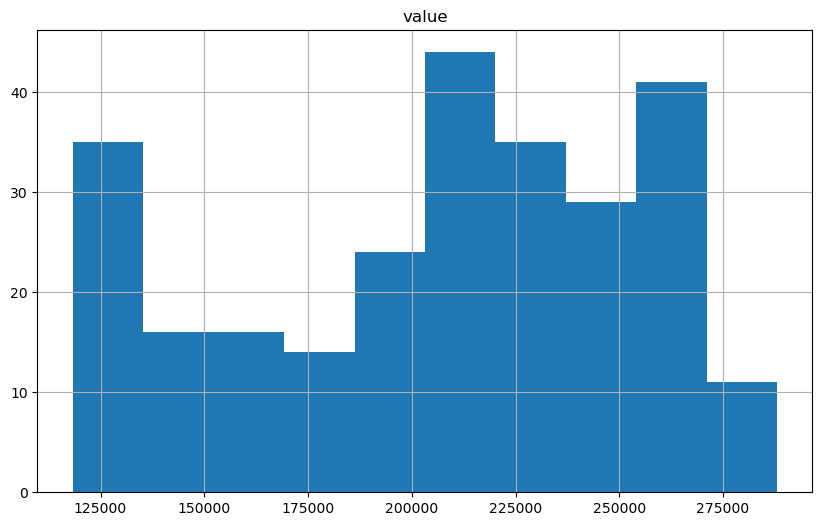

In [23]:
long_df.hist(figsize = (10,6));


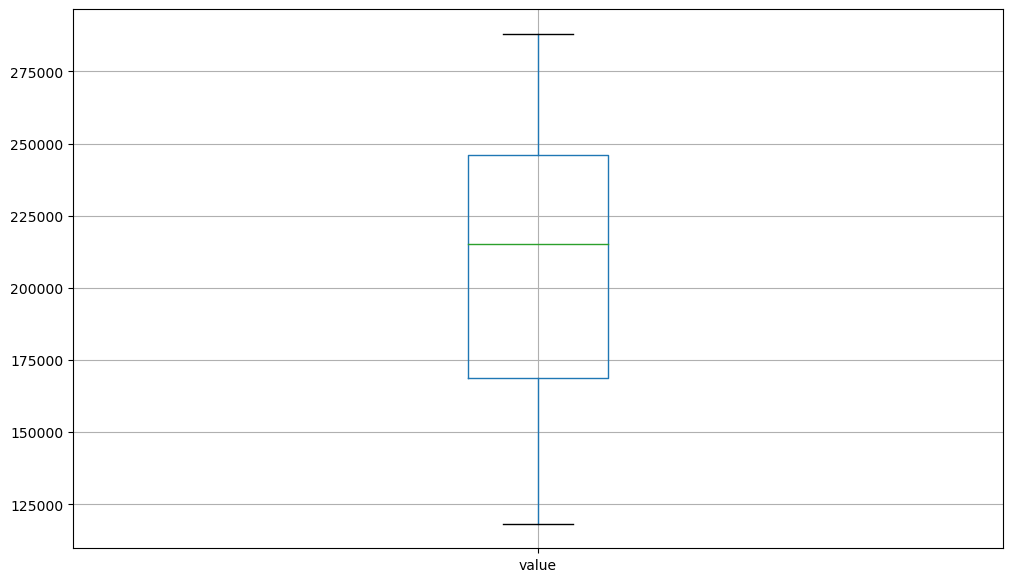

In [27]:
long_df.boxplot(figsize = (12,7));


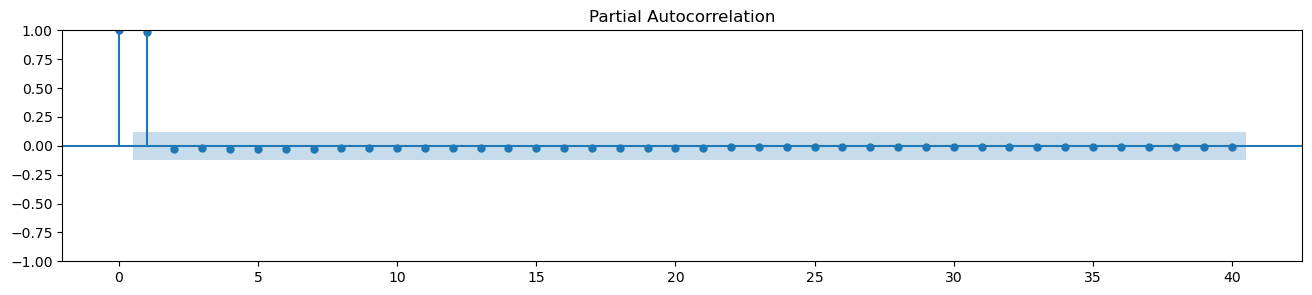

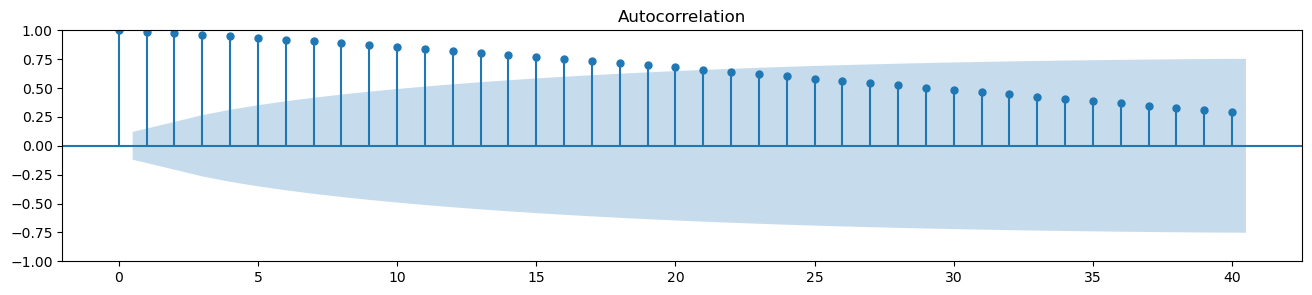

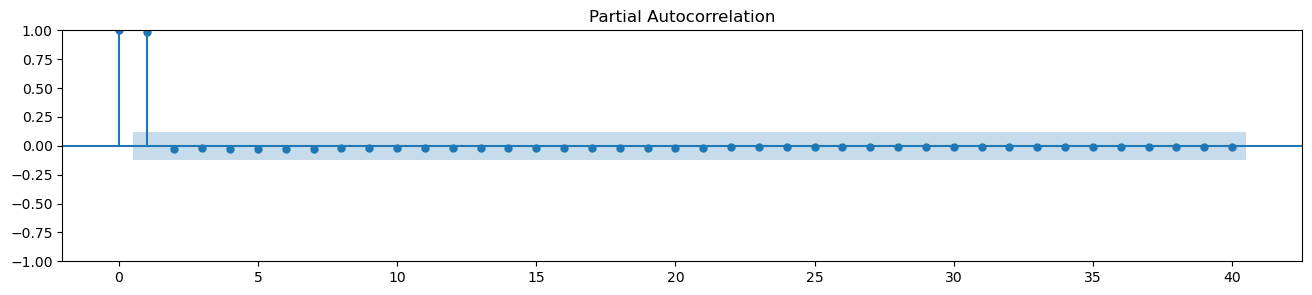

In [28]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(long_df, ax=ax, lags=40)

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(long_df, ax=ax, lags=40, method="ywm")

In [31]:
mod_arma = ARIMA(long_df, order=(1,0,0))

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
res_arma = mod_arma.fit()

In [33]:
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2281.305
Date:                Mon, 09 Oct 2023   AIC                           4568.609
Time:                        08:34:11   BIC                           4579.349
Sample:                    04-01-1996   HQIC                          4572.924
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.067e+05   1.52e-11   1.36e+16      0.000    2.07e+05    2.07e+05
ar.L1          0.9999      0.001    818.525      0.000       0.997       1.002
sigma2      1.704e+06   1.32e-12   1.29e+18      0.0

In [36]:
print(res_arma.params)

const     2.066615e+05
ar.L1     9.998726e-01
sigma2    1.704487e+06
dtype: float64


In [38]:
mod1_arma = ARIMA(long_df, order=(0,0,1))
res1_arma = mod1_arma.fit()

# Print out summary information on the fit
print(res1_arma.summary())

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3052.345
Date:                Mon, 09 Oct 2023   AIC                           6110.690
Time:                        08:43:51   BIC                           6121.429
Sample:                    04-01-1996   HQIC                          6115.005
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.067e+05   3502.228     59.008      0.000       2e+05    2.14e+05
ma.L1          1.0000      0.138      7.224      0.000       0.729       1.271
sigma2      6.303e+08   2.22e-06   2.84e+14      0.0

In [39]:
print(res1_arma.params)

const     2.066598e+05
ma.L1     9.999993e-01
sigma2    6.302589e+08
dtype: float64


In [26]:
data_diff = long_df.diff().dropna()
data_diff

,value
time,
1996-05-01,119.921076
1996-06-01,118.379129
1996-07-01,115.646010
1996-08-01,127.185034
1996-09-01,147.274189
...,...
2017-12-01,1574.461727
2018-01-01,1561.740134
2018-02-01,1711.628065


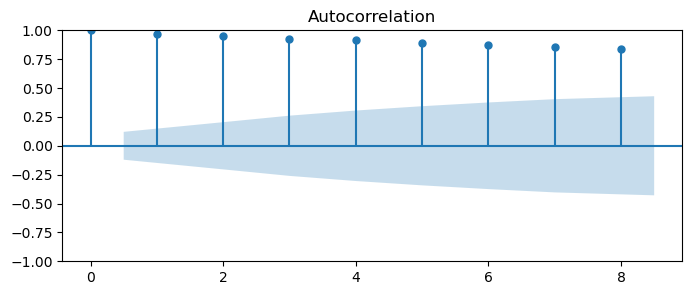

In [40]:
fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(data_diff, ax=ax, lags=8);

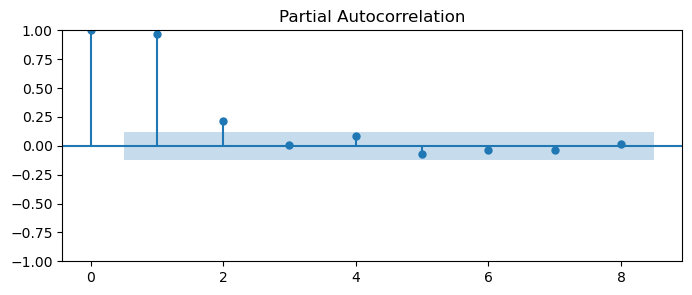

In [41]:
fig, ax = plt.subplots(figsize=(8, 3))
plot_pacf(data_diff, ax=ax, lags=8, method="ywm");

In [42]:
mod2_arma = ARIMA(data_diff, order=(1, 0, 0))
res2_arma = mod2_arma.fit()

# Print out summary information on the fit
print(res2_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  264
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1866.272
Date:                Mon, 09 Oct 2023   AIC                           3738.543
Time:                        08:44:59   BIC                           3749.271
Sample:                    05-01-1996   HQIC                          3742.854
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        642.9579    560.693      1.147      0.251    -455.980    1741.896
ar.L1          0.9665      0.011     84.321      0.000       0.944       0.989
sigma2      8.026e+04   1695.009     47.351      0.0

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [43]:
mod3_arma = ARIMA(data_diff, order=(2, 0, 1))
res3_arma = mod3_arma.fit()

# Print out summary information on the fit
print(res3_arma.summary())

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  264
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1857.342
Date:                Mon, 09 Oct 2023   AIC                           3724.684
Time:                        08:45:36   BIC                           3742.563
Sample:                    05-01-1996   HQIC                          3731.868
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        642.9880    711.448      0.904      0.366    -751.425    2037.401
ar.L1          0.7372      0.141      5.230      0.000       0.461       1.013
ar.L2          0.2381      0.134      1.777      0.0

In [44]:
mod4_arma = ARIMA(data_diff, order=(2, 0, 2))
res4_arma = mod4_arma.fit()

# Print out summary information on the fit
print(res4_arma.summary())

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA param

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  264
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1856.433
Date:                Mon, 09 Oct 2023   AIC                           3724.867
Time:                        08:47:07   BIC                           3746.323
Sample:                    05-01-1996   HQIC                          3733.489
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        642.9877    728.339      0.883      0.377    -784.531    2070.507
ar.L1          0.1143      0.216      0.530      0.596      -0.308       0.537
ar.L2          0.8504      0.215      3.964      0.0

# Modeling


# Evaluation

# Conclusions

# Next Steps and Limitations

# For More Information

See the full analysis in the [Jupyter Notebook](https://github.com/lalynjay/weather_classification/blob/main/weather_classification.ipynb) or review [this presentation](https://github.com/lalynjay/weather_classification/blob/main/weather_classification.pdf)

For additional info, contact Lynn Anderson at lalynjay@gmail.com

Repository Structure

├── data 

├── images

├── README.md

├── ts_presentation.pdf

└── notebook.ipynb